In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import gseapy as gp

sys.path.append("..")  # Adds the parent directory to the system path

# Correlation Between Gene Expression and Drug Sensitivity for a Given Target (PRISM & GDSC2)

This notebook assembles the analyses used to produce **Tables B.2 and B.3** in **Appendix B** (referenced in **Chapter 5** of the thesis). It screens drugs whose efficacy varies with the expression level of a gene of interest (e.g., *MTUS1* / ATIP3) across cancer cell lines, using  **PRISM** and **GDSC2** panels.

**Remark** PRISM and GDSC2 report different response metrics (e.g., PRISM LFC; GDSC2 AUC or ln(IC50)), but we harmonize them so that greater sensitivity points in the same direction across panels (more negative LFC is equivalent to lower AUC/IC50, mean more sensitivity). All downstream correlations respect this convention.

---

## 1. Load and explore data (Optional)

Load DepMap expression (log2(TPM+1)), cell-line metadata and mutation features, and  drug-response data from PRISM and/or GDSC2. 

Explore and perform basic sanity checks (dimensions, missingness, key coverage) and quick exploratory summaries.

## 2. Choose data

Define the analysis cohort and drug panel:

* Select PRISM or GDSC2,
* Apply simple filters (e.g., tissue/subtype, TNBC),
* Optionally restrict to drugs whose putative targets match a user-supplied gene list,
* Keep only the expression columns needed for correlation.

## 3. Correlation Between Gene Expression and Drug Sensitivity for a Given Target

For the chosen gene, compute per-drug correlations between expression and harmonized sensitivity across cell lines. Report:

* Drug name, putative target,
* Pearson coefficients, *p*-values, FDR (Benjamini–Hochberg),
* Sample size per drug, with optional plots (scatter + regression).

## 4. Pathway enrichment on putative targets

Run pathway/ontology enrichment on the putative targets of drugs that show significant association. Summarize enriched pathways with adjusted *p*-values and coverage, to contextualize mechanistic hypotheses.


# 1. Load and explore data (Optional)

## Data Sources

The files located in the `./data` folder were downloaded from the following official resources:

- [DepMap portal](https://depmap.org/portal/data_page/?tab=allData)
- [Genomics of Drug Sensitivity in Cancer (GDSC)](https://www.cancerrxgene.org/downloads)

These datasets include genomic and pharmacological data used throughout this analysis.

## A. Mutation (cell Line Name/COSMIC_ID/GDSC Desc1/GDSC Desc2/TCGA Desc)


In the file `PANCANCER_Genetic_features.csv`, downloaded from  [Genomics of Drug Sensitivity in Cancer (GDSC)](https://www.cancerrxgene.org/downloads),  
we have access to the following information for each cell line:

- **Cell Line Name**
- **COSMIC_ID**
- **GDSC Desc1**
- **GDSC Desc2**
- **TCGA Desc**
- and the list of **mutations** identified in each sample.

In [35]:
# Load the genetic features dataset from a CSV file
Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")

# Rename the column 'COSMIC ID' to 'COSMIC_ID' for easier access and consistency
Genetic_features.rename(columns={'COSMIC ID': 'COSMIC_ID'}, inplace=True)

# Show to explore the dataset
# - the tumor type (TCGA Desc) is 'BRCA' (breast cancer)
# - and the genetic feature is 'KRAS_mut' (mutation in KRAS gene): only 2 cell-lines have this mutation
Genetic_features[(Genetic_features["TCGA Desc"] == 'BRCA') & 
                 (Genetic_features['Genetic Feature'] == 'KRAS_mut')]


/var/folders/zg/y03kdtc553xg5q1ct59rj44c0000gn/T/ipykernel_56625/4210660839.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")


,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
1794,CAL-51,910927,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
426320,COLO-824,906812,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
427145,CAL-85-1,910852,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
431528,CAMA-1,946382,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
441500,CAL-120,906826,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
446319,CAL-148,924106,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
447226,AU565,910704,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
448808,BT-20,906801,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
450294,BT-474,946359,breast,breast,BRCA,KRAS_mut,0,NaN,NaN
451769,BT-483,949093,breast,breast,BRCA,KRAS_mut,0,NaN,NaN


In [36]:
# Create a new column with the mutated genes
def get_mutated_genes(row):
    mutated_genes = []

    # Check if the feature is marked as mutated
    if row['IS Mutated'] == 1:
        
        # Check if the gene name contains "_mut" in the 'Genetic Feature' column
        if '_mut' in row['Genetic Feature']:
            gene_name = row['Genetic Feature'].replace('_mut', '')
            mutated_genes.append(gene_name)
    
    # Return a list of unique gene names (remove duplicates)
    return list(set(mutated_genes))

# Apply the function to each row of the DataFrame to create the 'Mutated Genes' column
Genetic_features['Mutated Genes'] = Genetic_features.apply(get_mutated_genes, axis=1)

# Aggregate genetic features by cell line, keeping the first descriptions and merging unique mutated genes per group
grouped_Genetic_features = Genetic_features.groupby(['Cell Line Name', 'COSMIC_ID']).agg({
    'GDSC Desc1': 'first',
    'GDSC Desc2': 'first',
    'TCGA Desc': 'first',
    'Mutated Genes': lambda x: list(set([gene for sublist in x for gene in sublist]))
}).reset_index()
grouped_Genetic_features

,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
0,22RV1,924100,urogenital_system,prostate,PRAD,"[ARID1A, NUP93, ZMYM2, INPPL1, SPTAN1, BRCA2, ..."
1,23132-87,910924,digestive_system,stomach,STAD,"[ARID1A, CTCF, SPTAN1, STAG2, CDKN1A, CHD6, CA..."
2,42-MG-BA,687561,nervous_system,glioma,GBM,"[STAG2, PTEN, TP53, RB1]"
3,451Lu,1287706,skin,melanoma,SKCM,"[ROBO2, BRAF, TP53]"
4,5637,687452,urogenital_system,bladder,BLCA,"[POLR2B, RB1, ERBB2, TP53]"
...,...,...,...,...,...,...
964,YT,946358,blood,lymphoid_neoplasm_other,ALL,[ARID4A]
965,ZR-75-30,909907,breast,breast,BRCA,"[CDH1, CHD3, DICER1]"
966,huH-1,1298146,digestive_system,liver,LIHC,"[AXIN1, TP53]"
967,no-10,908452,nervous_system,glioma,LGG,"[MLL, RB1, TP53]"


In [37]:
# Show to explore the dataset
TCGA_type = 'BRCA'  # Example TCGA type
# Filter the grouped DataFrame for a specific TCGA type 
print("number of cell-lines:",len(grouped_Genetic_features[(grouped_Genetic_features["TCGA Desc"] == TCGA_type)]))
grouped_Genetic_features[(grouped_Genetic_features["TCGA Desc"] == TCGA_type)]

number of cell-lines: 51


,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
40,AU565,910704,breast,breast,BRCA,"[PLXNB2, KIT, LRPPRC, TP53]"
63,BT-20,906801,breast,breast,BRCA,"[KDR, TP53, PIK3CA, WHSC1, ARHGEF6]"
64,BT-474,946359,breast,breast,BRCA,"[HNF1A, BRCA2, TP53, PIK3CA, CUX1]"
65,BT-483,949093,breast,breast,BRCA,"[STAG2, TP53, PIK3CA]"
66,BT-549,905951,breast,breast,BRCA,"[MACF1, PTEN, TP53]"
78,CAL-120,906826,breast,breast,BRCA,[TP53]
80,CAL-148,924106,breast,breast,BRCA,"[PTEN, ARID4B, TP53, PIK3CA]"
85,CAL-51,910927,breast,breast,BRCA,"[ARID1A, MAP2K4, POLR2B, AHNAK, PTEN, ATRX, SA..."
90,CAL-85-1,910852,breast,breast,BRCA,"[BRCA2, ASH1L, TP53]"
91,CAMA-1,946382,breast,breast,BRCA,"[PTEN, CDH1, INPPL1, TP53, SIN3A]"


In [38]:
# Show to explore the dataset
# List of cell lines with specific mutated genes
list_mut = ['KRAS','BRAF']#,'HRAS','BRAF']
grouped_Genetic_features[(grouped_Genetic_features["TCGA Desc"] == 'BRCA') & (grouped_Genetic_features["Mutated Genes"].apply(lambda x: any(gene in x for gene in list_mut)))]

,Cell Line Name,COSMIC_ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
173,DU-4475,906844,breast,breast,BRCA,"[BRAF, APC]"
469,MDA-MB-231,905960,breast,breast,BRCA,"[NF2, FTSJD1, TP53, ARFGEF1, KRAS, NF1, BRWD1,..."
963,YMB-1-E,1303911,breast,breast,BRCA,"[PTEN, MEN1, FAT2, KRAS, MLLT4]"


## B. Metadata (DepMap_ID / COSMICID)

In the file `Model.csv`, downloaded from the  [DepMap portal](https://depmap.org/portal/data_page/?tab=allData),  
we have access to metadata describing all cancer models (cell lines) that are referenced by datasets included in the DepMap portal.  
This includes key identifiers such as **DepMap_ID** and **COSMICID**.

In [39]:
meta = pd.read_csv("../data/Cell-lines/Model.csv") 
meta.rename(columns={'ModelID': 'DepMap_ID', 'COSMICID':'COSMIC_ID' }, inplace=True)
meta[meta["COSMIC_ID"] == 906863]

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID
842,ACH-000846,PT-tolPHE,FaDu,FADU,HPHSC,Head and Neck,Head and Neck Squamous Cell Carcinoma,Hypopharynx Squamous Cell Carcinoma,HPHSC,NaN,...,NaN,NaN,NaN,FADU_UPPER_AERODIGESTIVE_TRACT,NaN,Available in SRA,NaN,1170.0,SIDM00860,906863.0


In [40]:
# Show to explore the dataset
meta[meta['OncotreeLineage'].str.contains('Breast', na=False)]

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID
15,ACH-000017,PT-8CE6ah,SK-BR-3,SKBR3,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,NaN,SKBR3_BREAST,NaN,Available in SRA,HER2+,NaN,SIDM00897,NaN
17,ACH-000019,PT-viJKnw,MCF7,MCF7,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,NaN,MCF7_BREAST,NaN,Available in SRA,ER+,588.0,SIDM00148,905946.0
26,ACH-000028,PT-viJKnw,KPL-1,KPL1,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,SNP fingerprinting confirms that this line is ...,KPL1_BREAST,NaN,Available in SRA,ER+,NaN,SIDM00147,NaN
42,ACH-000044,PT-HMBfbj,MDA-MB-134-VI,MDAMB134VI,ILC,Breast,Invasive Breast Carcinoma,Breast Invasive Lobular Carcinoma,ILC,NaN,...,NaN,NaN,NaN,MDAMB134VI_BREAST,NaN,Available in SRA,luminal ER+,NaN,SIDM00005,NaN
95,ACH-000097,PT-k1TO7o,ZR-75-1,ZR751,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,ZR751_BREAST,NaN,Available in SRA,"luminal ER, PR+",NaN,SIDM00314,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,ACH-002884,PT-N65Hvq,IPM-BO-055,IPMBO055,ILC,Breast,Invasive Breast Carcinoma,Breast Invasive Lobular Carcinoma,ILC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,HER2+,NaN,NaN,NaN
1999,ACH-002885,PT-pPJgGC,IPM-BO-056,IPMBO056,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"ER, PR+",NaN,NaN,NaN
2001,ACH-002921,PT-NvrCXN,BCK4,BCK4,ILC,Breast,Invasive Breast Carcinoma,Breast Invasive Lobular Carcinoma,ILC,NaN,...,NaN,NaN,NaN,NaN,NaN,In Progress,NaN,NaN,NaN,NaN
2013,ACH-002950,PT-hxORJf,NH93T,NH93T,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TNBC,NaN,NaN,NaN


In [41]:
# Show to explore the dataset
# List of cell lines with specific subtype
meta[meta['ModelSubtypeFeatures'].str.contains('TNBC', na=False)]

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID
109,ACH-000111,PT-yKJqsn,HCC1187,HCC1187,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,HCC1187_BREAST,NaN,Available in SRA,basal_A TNBC,1644.0,SIDM00885,749711.0
146,ACH-000148,PT-sW6DWH,Hs 578T,HS578T,BRCNOS,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",BRCNOS,NaN,...,NaN,NaN,NaN,HS578T_BREAST,NaN,Available in SRA,basal_B TNBC,655.0,SIDM00135,905957.0
194,ACH-000196,PT-ZerhVq,HCC1599,HCC1599,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,HCC1599_BREAST,NaN,Available in SRA,basal_A TNBC,1264.0,SIDM00877,749713.0
210,ACH-000212,PT-y6HadC,CAL-120,CAL120,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,NaN,CAL120_BREAST,NaN,Available in SRA,basal_B TNBC,1748.0,SIDM00940,906826.0
221,ACH-000223,PT-Vntr9y,HCC1937,HCC1937,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,HCC1937_BREAST,NaN,Available in SRA,basal_A TNBC,936.0,SIDM00874,749714.0
256,ACH-000258,PT-XTyUEa,Du4475,DU4475,BRCA,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,BRCA,NaN,...,NaN,NaN,NaN,DU4475_BREAST,NaN,Available in SRA,luminal TNBC,302.0,SIDM01001,906844.0
274,ACH-000276,PT-S4bLNM,HCC38,HCC38,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,HCC38_BREAST,NaN,Available in SRA,basal_A TNBC,1318.0,SIDM00675,749717.0
286,ACH-000288,PT-hgWgpg,BT-549,BT549,BRCNOS,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",BRCNOS,NaN,...,NaN,NaN,NaN,BT549_BREAST,NaN,Available in SRA,basal_B TNBC,1835.0,SIDM00122,905951.0
372,ACH-000374,PT-UPBMOO,HCC1143,HCC1143,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,NaN,HCC1143_BREAST,NaN,Available in SRA,basal_A TNBC,1316.0,SIDM00866,749710.0
532,ACH-000536,PT-jtQBfm,BT-20,BT20,IDC,Breast,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,IDC,NaN,...,NaN,NaN,SNP fingerprinting rules out HeLa contamination.,BT20_BREAST,NaN,Available in SRA,basal_A TNBC,2264.0,SIDM00893,906801.0


In [42]:
# Merge meta information with grouped genetic features
meta_grouped_Genetic_features = meta.merge(grouped_Genetic_features, on='COSMIC_ID',how = 'left')
meta_grouped_Genetic_features.head()

,DepMap_ID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMIC_ID,Cell Line Name,GDSC Desc1,GDSC Desc2,TCGA Desc,Mutated Genes
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,...,Available in SRA,NaN,2201.0,SIDM00105,905933.0,OVCAR-3,urogenital_system,ovary,OV,"[PIK3R1, TP53]"
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"TP53(del), CDKN2A and NRAS mutations [PubMed=2...",...,Available in SRA,NaN,55.0,SIDM00829,905938.0,HL-60,blood,acute_myeloid_leukaemia,LAML,"[NRAS, CDKN2A]"
2,ACH-000003,PT-puKIyc,CACO2,CACO2,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,NaN,...,Available in SRA,NaN,NaN,SIDM00891,NaN,NaN,NaN,NaN,NaN,NaN
3,ACH-000004,PT-q4K2cp,HEL,HEL,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"JAK2 and TP53 mutations,",...,Available in SRA,NaN,783.0,SIDM00594,907053.0,HEL,blood,acute_myeloid_leukaemia,LAML,[]
4,ACH-000005,PT-q4K2cp,HEL 92.1.7,HEL9217,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,JAK2 and TP53 mutations,...,Available in SRA,NaN,NaN,SIDM00593,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Show to explore the dataset
TCGA_type = 'BRCA'  
print(f"number of cell-lines of tcga-{TCGA_type}:",len(meta_grouped_Genetic_features[(meta_grouped_Genetic_features["TCGA Desc"] == TCGA_type)]))

number of cell-lines of tcga-BRCA: 49


In [44]:
# Show to explore the dataset
print("number of cell-lines of Breast:",len(meta_grouped_Genetic_features[meta_grouped_Genetic_features['OncotreeLineage'].str.contains('Breast', na=False)]))
print("number of TNBC cell-lines:",len(meta_grouped_Genetic_features[meta_grouped_Genetic_features['ModelSubtypeFeatures'].str.contains('TNBC', na=False)]))

number of cell-lines of Breast: 96
number of TNBC cell-lines: 34


## C. Drug Response  (GDSC2 (COSMIC_ID/CELL_LINE_NAME/TCGA_DESC) + PRISM)

### 1. GDSC2

In the file `GDSC2_fitted_dose_response_27Oct23.csv`, located in the `../data/Cell-lines/` folder and downloaded from the  [Genomics of Drug Sensitivity in Cancer (GDSC)](https://www.cancerrxgene.org/downloads),  
we have dose-response data for multiple drugs tested across cancer cell lines.

This dataset includes:

- **COSMIC_ID**: unique identifier for each cell line
- **TCGA_DESC**: cancer type (e.g., BRCA for breast cancer)
- Drug response metrics such as **LN_IC50**, **AUC**, and fitted dose-response curves

This data allows us to explore drug sensitivity in specific cancer types or in individual cell lines (e.g., filtering by `COSMIC_ID`).


In [45]:
# Load GDSC2 drug response data (dose-response curves) from the CSV file
gdsc2 = pd.read_csv("../data/Cell-lines/GDSC2_fitted_dose_response_27Oct23.csv", sep = ';')
gdsc2[gdsc2['COSMIC_ID'] == 1290906]

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
2360,GDSC2,343,16150333,1290906,HCC202,SIDM00870,BRCA,1005,Cisplatin,DNA crosslinker,DNA replication,1046,Y,"0,003906",4,"4,447555","0,992215","0,031864","0,665068"
4014,GDSC2,343,16150334,1290906,HCC202,SIDM00870,BRCA,1007,Docetaxel,Microtubule stabiliser,Mitosis,1046,Y,"0,000012","0,0125","-2,033707","0,984954","0,064277","1,482672"
7045,GDSC2,343,16150335,1290906,HCC202,SIDM00870,BRCA,1011,Navitoclax,"BCL2, BCL-XL, BCL-W",Apoptosis regulation,1046,Y,"0,009766",10,"1,851678","0,859966","0,133674","0,056666"
8007,GDSC2,343,16150336,1290906,HCC202,SIDM00870,BRCA,1012,Vorinostat,"HDAC inhibitor Class I, IIa, IIb, IV",Chromatin histone acetylation,1046,Y,"0,004883",5,"1,003058","0,846018","0,08414","-0,445503"
15604,GDSC2,343,16150337,1290906,HCC202,SIDM00870,BRCA,1021,Axitinib,"PDGFR, KIT, VEGFR",RTK signaling,1046,Y,"0,009766",10,"2,677585","0,920447","0,046866","-0,134191"
16566,GDSC2,343,16150338,1290906,HCC202,SIDM00870,BRCA,1022,AZD7762,"CHEK1, CHEK2",Cell cycle,1046,Y,"0,000977",1,"-0,048338","0,892356","0,065747","-0,13324"
25380,GDSC2,343,16150339,1290906,HCC202,SIDM00870,BRCA,1034,Staurosporine,Broad spectrum kinase inhibitor,RTK signaling,1046,Y,"0,007813",2,"-2,134052","0,491443","0,069677","0,476009"
31566,GDSC2,343,16150340,1290906,HCC202,SIDM00870,BRCA,1047,Nutlin-3a (-),MDM2,p53 pathway,1046,Y,"0,009766",10,"5,11512","0,990186","0,036025","0,391102"
33428,GDSC2,343,16150341,1290906,HCC202,SIDM00870,BRCA,1049,PD173074,"FGFR1, FGFR2, FGFR3",RTK signaling,1046,Y,"0,009766",10,"5,132866","0,990346","0,081367","0,979552"
37243,GDSC2,343,16150342,1290906,HCC202,SIDM00870,BRCA,1053,MK-2206,"AKT1, AKT2",PI3K/MTOR signaling,1046,Y,"0,009766",10,"1,585278","0,8356","0,180727","-0,766362"


In [46]:
gdsc2.value_counts('PATHWAY_NAME')

PATHWAY_NAME
Unclassified                         24979
PI3K/MTOR signaling                  22724
Other                                21402
DNA replication                      17650
Other, kinases                       17277
ERK MAPK signaling                   13350
Genome integrity                     12221
Cell cycle                           11620
Apoptosis regulation                 10828
Chromatin histone methylation        10612
RTK signaling                        10573
Chromatin other                       8576
Chromatin histone acetylation         8162
WNT signaling                         7631
Protein stability and degradation     7087
EGFR signaling                        6734
Mitosis                               6453
IGF1R signaling                       5512
Metabolism                            4802
Hormone-related                       3820
p53 pathway                           3776
Cytoskeleton                          3387
JNK and p38 signaling                 190

In [47]:
gdsc2.value_counts('TCGA_DESC')

TCGA_DESC
UNCLASSIFIED    45691
LUAD            15653
SCLC            13570
BRCA            13106
SKCM            12637
COREAD          12538
HNSC             9358
ESCA             9126
GBM              8384
OV               8166
DLBC             7978
PAAD             7513
NB               7469
KIRC             7462
ALL              6795
LAML             6209
STAD             6060
MESO             5561
BLCA             4724
MM               4598
LIHC             4164
THCA             4037
LUSC             3863
CESC             3811
LGG              3617
LCML             2611
UCEC             2512
PRAD             1676
MB               1072
CLL               550
ACC               279
OTHER             179
Name: count, dtype: int64

### 2. PRISM Repurposing

In this section, we use three files from the PRISM Repurposing dataset (24Q2), provided by the  
[DepMap portal](https://depmap.org/portal/data_page/?tab=allData):

- `Repurposing_Public_24Q2_LFC_COLLAPSED.csv`: log fold change (LFC) measurements representing drug response for each cell line. 
**File to be downloaded**

- `Repurposing_Public_24Q2_Cell_Line_Meta_Data.csv`: metadata for cell lines, including `DepMap_ID` and `ccle_name`
- `Repurposing_Public_24Q2_Extended_Primary_Compound_List.csv`: drug metadata, including names, targets, and mechanism of action

From these, we build a cleaned DataFrame containing:

- **Cell line information**: `ccle_name`, `DepMap_ID`, and derived fields like `CELL_LINE_NAME` and cancer `Origin`
- **Drug information**: `DRUG_NAME`, `PUTATIVE_TARGET`, `PATHWAY_NAME`, and PRISM `AUC` (based on LFC; more negative = more sensitive)
- A constant column `DATASET` set to `"PRISM"` to distinguish it from other datasets like GDSC2

Note: The LFC values in PRISM are interpreted as sensitivity scores. A value around -1 indicates approximately 50% reduction in viability.


In [48]:
# Load the necessary files from the PRISM Repurposing 24Q2 dataset
lfc = pd.read_csv("../data/Cell-lines/Repurposing_Public_24Q2_LFC_COLLAPSED.csv")
cell_meta = pd.read_csv("../data/Cell-lines/Repurposing_Public_24Q2_Cell_Line_Meta_Data.csv")
drug_meta = pd.read_csv("../data/Cell-lines/Repurposing_Public_24Q2_Extended_Primary_Compound_List.csv")

# Keep only relevant columns from cell and drug metadata
cell_meta = cell_meta[['row_id', 'ccle_name', 'depmap_id']]
drug_meta = drug_meta[['IDs', 'Drug.Name', 'repurposing_target', 'MOA']]

# Clean the 'IDs' column by removing the 'BRD:' prefix to match with 'broad_id' in lfc
drug_meta['IDs'] = drug_meta['IDs'].str.replace('^BRD:', '', regex=True)

# Merge drug response data with cell line metadata to get cell line names
df = lfc.merge(cell_meta, on='row_id', how='left')

# Merge with drug metadata to get drug names, targets, and MOA
df = df.merge(drug_meta, left_on='broad_id', right_on='IDs', how='left')

# Drop entries with missing drug IDs (unmatched merges)
df = df.dropna(subset=['IDs'])

# Add a constant column indicating the dataset source
df['DATASET'] = 'PRISM'

# Rename depmap_id to match GDSC2 naming convention
df = df.rename(columns={'depmap_id': 'DepMap_ID'})

# Extract cell line name and cancer origin from the 'ccle_name' field
df[['CELL_LINE_NAME', 'Origin']] = df['ccle_name'].str.split('_', n=1, expand=True)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Rename columns to harmonize with the GDSC2 format
df_prism = df.rename(columns={
    'Drug.Name': 'DRUG_NAME',
    'repurposing_target': 'PUTATIVE_TARGET',
    'MOA': 'PATHWAY_NAME',
    #'LFC': 'AUC',  # In PRISM, LFC is inversely related to sensitivity: more negative = more sensitive
    'COSMICID': 'COSMIC_ID'  # This column may not be available unless merged externally
})

# Reorder and select final columns for the standardized output
df_prism = df_prism[[
    'DATASET', 'ccle_name', 'CELL_LINE_NAME', 'Origin', 'DepMap_ID', 'IDs', 'DRUG_NAME',
    'PUTATIVE_TARGET', 'PATHWAY_NAME', 'LFC'
]]

# Show the first few rows of the final processed PRISM DataFrame
df_prism.head()



,DATASET,ccle_name,CELL_LINE_NAME,Origin,DepMap_ID,IDs,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,LFC
0,PRISM,NIHOVCAR3_OVARY,NIHOVCAR3,OVARY,ACH-000001,BRD-A04843135-001-09-9,OXAMNIQUINE,NaN,NaN,-0.142011
2,PRISM,NIHOVCAR3_OVARY,NIHOVCAR3,OVARY,ACH-000001,BRD-A49924714-001-08-9,2-ETHYLHEXYL 4-(DIMETHYLAMINO)BENZOATE,NaN,NaN,0.340703
3,PRISM,NIHOVCAR3_OVARY,NIHOVCAR3,OVARY,ACH-000001,BRD-K00003538-001-02-9,ACT-709478,NaN,NaN,-0.011331
4,PRISM,NIHOVCAR3_OVARY,NIHOVCAR3,OVARY,ACH-000001,BRD-K00005263-001-02-9,MIK665,NaN,NaN,-0.471235
5,PRISM,NIHOVCAR3_OVARY,NIHOVCAR3,OVARY,ACH-000001,BRD-K00010521-300-02-9,KB-0742 (DIHYDROCHLORIDE),NaN,NaN,-5.424189


In [49]:
df_prism.value_counts('PUTATIVE_TARGET')

PUTATIVE_TARGET
P2RX7                                                 5586
BRAF, RAF1                                            5580
GRM1                                                  4655
CHRNA7                                                4655
ABL1, CSF1R, DDR1, KIT, NTRK1, PDGFRA, PDGFRB, RET    3724
                                                      ... 
ERBB2                                                  931
EIF2AK3, MYLK2                                         931
EIF2A, EIF2AK3                                         931
EGLN1, KDM3A, KDM4C, KDM6B                             931
ZNF215                                                 931
Name: count, Length: 361, dtype: int64

## D. Gene Expression (DepMap 24Q4)

We use the file `OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv` from the  [DepMap portal](https://depmap.org/portal/download/), which contains batch-corrected log-transformed TPM values  for protein-coding genes across cancer cell lines.

**File to be downloaded**

Steps:
- Set `DepMap_ID` as a column for merging with other datasets
- Clean column names by removing gene annotations in parentheses (e.g., gene IDs or descriptions)


1673 cell lines/ 19139 genes

In [50]:
# Load DepMap 24Q4 expression data (log-transformed TPM, batch corrected)
# Set 'DepMap_ID' as a column instead of index
# Clean column names by removing anything in parentheses and trimming whitespace
df = pd.read_csv("../data/Cell-lines/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv", index_col=0) #DepMap Public 24Q4
df.index.name = 'DepMap_ID'
df = df.reset_index()
df.columns = df.columns.str.extract(r'^([^\(]+)', expand=False).str.strip()
df.rename(columns={'COSMICID': 'COSMIC_ID'}, inplace=True)
print(df.shape)
df.head(5)
#df = df[['DepMap_ID','MTUS1','MYC','MAPT','MAPK3','MAPK1','MAP2K1','MAP2K2','JAK1','JAK2','JAK3','AKT1','AKT2','AKT3','PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS','KIF2A','MAST4',]]

(1673, 19139)


,DepMap_ID,TFE3,MMADHC,PABPC1L,RELL2,GPT,GUSB,H4-16,DDB2,RPS4X,...,OR2A42,HOXB7,NSA2,UGT2B11,ZNF747,NAA60,MYH4,MTAP,C14orf93,NR3C2
0,ACH-000873,3.607691,3.531071,4.982285,2.326016,0.607679,5.118549,1.282028,4.512297,10.075438,...,0.042564,3.870581,5.178480,-0.007723,2.005498,4.213717,-0.001724,3.904800,2.190931,0.203910
1,ACH-000860,4.192566,6.865682,4.853288,2.725583,0.197016,5.666426,1.154470,4.306808,10.215240,...,0.031621,-0.005897,6.749713,-0.007723,1.393644,4.334535,-0.001724,4.812949,3.366939,0.370726
2,ACH-000439,3.265517,5.804615,1.777636,4.185835,0.389025,6.593342,0.410244,4.411381,11.644890,...,-0.013226,-0.033868,6.877322,1.596383,3.143557,4.624226,-0.001724,4.122929,2.197136,0.015412
3,ACH-000318,3.705500,5.813170,4.536005,2.290409,0.471169,5.160089,2.325673,5.017968,9.163992,...,-0.013226,3.051092,5.610027,-0.007723,2.334419,3.881219,-0.001724,0.394778,3.217293,0.277760
4,ACH-001142,6.105227,7.051513,4.457555,2.543055,0.022363,4.589966,2.369987,4.105131,10.179188,...,0.053402,3.582671,7.416571,-0.007723,2.294077,4.889203,-0.001724,4.379944,2.355443,0.520338


# 2. Choose Data

This section assembles a single, analysis-ready table by joining gene expression, metadata/mutations, and drug-response measurements.

Function: `load_data_sensitivity_v1(dict_filters, list_mutation, target_genes, gdsc_n='gdsc2', drop_mutation=False, keep_only_mutation=False, expr_keep=[])`
Returns a single DataFrame after:

* loading DepMap RNA-seq (keeping only `expr_keep genes`) and attaching metadata,
* applying simple cohort filters (`dict_filters`),
* optionally keeping/removing lines mutated in genes from `list_mutation`,
* selecting a drug panel (GDSC2 or PRISM) and (optionally) restricting compounds to `target_genes`,
* merging on the right key (PRISM → DepMap_ID, GDSC2 → COSMIC_ID) and dropping duplicates.

Output:
One row per (drug, cell line) with: IDs, selected expression columns, metadata/mutation flags, DRUG_NAME, PUTATIVE_TARGET, and the raw response metric from the chosen panel.

Remark on drug-response measures:
GDSC2 and PRISM report different metrics (e.g., AUC/ln(IC50) for GDSC2 vs LFC for PRISM), but their direction is the same for our purpose: values corresponding to greater sensitivity go in the same direction across panels (lower AUC/IC50 and more negative LFC both indicate more sensitive cell lines). In the next section, we treat the direction consistently.


In [2]:
from src.Depmap_utils import load_data_sensitivity

# Define the database for drug sensitivity data
sensibility_database = 'gdsc2' #  gdsc2, prism

# Define filtering conditions for the dataset
conditions = {
    #'TCGA Desc': lambda col: col.str.contains('PAAD', na=False),
    'OncotreeSubtype': lambda col: col.str.contains('Breast', na=False),
    #'OncotreeCode':lambda col: col.str.contains('COAD', na=False),              # same as merged_df = merged_df[merged_df['TCGA_DESC'] == 'BLCA'] but wrong for LGG, BRCA
    #'ModelSubtypeFeatures': lambda col: col.str.contains('TNBC', na=False),
    #'PrimaryOrMetastasis': lambda col: col.str.contains('Primary', na=False),   
}

# Define target genes for drug response analysis
#target_genes = ['BRAF']
target_genes = []

# Load and filter mutation data
#list_mutation = ['KRAS', 'BRAF', 'NRAS','RAF1','HRAS']#,'PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS'
list_mutation = ['PIK3CA','PTEN']
drop_mut = False
keep_only_mut = False

# Define genes to keep in the expression data
expr_keep=['HMGB2','RPS16','PSMB5','DDX10','MTUS1','FOXO3', 'CDX2','MYC','MAPT','MAPK3','MAPK1','MAP2K1','MAP2K2','JAK1','JAK2','JAK3','AKT1','AKT2','AKT3','PIK3CA','KRAS', 'BRAF', 'NRAS','RAF1','HRAS','KIF2A','MAST4','WEE1','HSP90AB1','HSP90AA1','BRD4','CHEK1','CHEK2','ATM','ATR','AURKB','AURKA','SMC1A','CDC45','PLK1'] #,'TP53','CDKN2A','RB1','MTUS1' #,'MTUS1','ATIP3a','ATIP1','ATIP4','ATIP3b'

merged_df = load_data_sensitivity(conditions,list_mutation,target_genes,gdsc_n = sensibility_database, drop_mutation = drop_mut, keep_only_mutation = keep_only_mut,expr_keep = expr_keep)
print("nombre de cell lines", merged_df['DepMap_ID'].drop_duplicates().shape[0])
print("nombre de drugs", merged_df['DRUG_NAME'].drop_duplicates().shape[0])
# Display the first few rows of the merged DataFrame
merged_df.head()

/Users/gguichaoua/Dropbox/gwenn/these/TNBC/ATIP3/tests/../src/Depmap_utils.py:45: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  Genetic_features = pd.read_csv("../data/Cell-lines/PANCANCER_Genetic_features_2025_04_07.csv")


nombre de cell lines 45
nombre de drugs 286


,DepMap_ID,HMGB2,RPS16,PSMB5,DDX10,MTUS1,FOXO3,CDX2,MYC,MAPT,...,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
5182,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.1177,1.404226,...,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,1046,Y,"0,010005",10,"1,699128","0,806363","0,137863","-0,617585"
5001,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.1177,1.404226,...,ESR1,Hormone-related,1046,Y,"0,010005",10,"3,209733","0,908307","0,134999","-0,626193"
5000,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.1177,1.404226,...,"ROCK1, ROCK2",Cytoskeleton,1046,Y,"0,009766",10,"2,448571","0,864032","0,122907","-0,026302"
4999,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.1177,1.404226,...,Proteasome,Protein stability and degradation,1046,Y,"0,00002","0,02","-6,011917","0,658772","0,200164","-1,193471"
4998,ACH-000148,6.941685,10.461861,6.930037,5.440451,0.223787,4.010513,-0.058704,6.1177,1.404226,...,Pyrimidine antimetabolite,DNA replication,1046,Y,"0,0001",10,"1,962251","0,895316","0,153024","0,906509"


# 3. Correlation Between Gene Expression and Drug Sensitivity for a Given Target

This section evaluates how the expression of a specific gene (e.g., *MTUS1*) correlates with the sensitivity of cancer cell lines to various drugs.

### Functions Used:

- **`correl_expression_measure_sensitivity(df, expr_col, measure_col)`**  
  Computes the Pearson (or Spearman) correlation between the expression of a gene (or the level of a protein) and a drug response metric (e.g., AUC (Gdsc2), LN_IC50 (Gdsc2), LFC (Prism)) across cell lines.

- **`correlations_expression_measure_all_drugs_sensitivity(df, expr_col, measure_col, drug_col)`**  
  Iterates over all drugs in the dataset and computes the correlation between gene expression and drug response individually for each compound.  
  Returns a DataFrame summarizing:
  - Drug name
  - Correlation coefficient
  - p-value
  - Number of samples
  - Putative drug target and pathway (if available)

- **`plot_expr_vs_measure_sensitivity(df, drug_name, expr_col, measure_col)`**  
  Generates a scatterplot with regression line showing the relationship between gene expression and drug response for a specific drug.  
  Optionally highlights subgroups (e.g., TNBC cell lines) if such annotations exist.

These tools allow screening of drugs whose efficacy may be associated with the expression level of a specific gene, which can support biomarker discovery or mechanistic hypotheses.

---

### Biological Interpretation

In this analysis, we focus on *MTUS1* / ATIP3, a tumor suppressor whose low expression is associated with more aggressive tumor phenotypes, particularly in triple-negative breast cancer (TNBC).

We are interested in identifying drugs that are more effective in ATIP3-low cells.

A significant **positive correlation** (e.g., r > 0, p < 0.05) between MTUS1 expression and a drug response measure like AUC (or LFC) suggests that:
- Lower MTUS1 expression is associated with lower drug response measure
- In other words, the drug is more effective when ATIP3 is low
- This may point to therapeutic opportunities in ATIP3-deficient tumors 

A **negative correlation** could imply that higher MTUS1 expression sensitizes cells to the drug, which is not the primary scenario of interest here.

This analysis helps:
- Identify drugs that may be selectively effective in aggressive, ATIP3-low cancers
- Reveal dependencies or vulnerabilities resulting from loss of ATIP3
- Support targeted treatment strategies based on gene expression profiles

In [3]:
# Compute correlations between expression and drug response measures
from src.Depmap_utils import correlations_expression_measure_all_drugs_sensitivity

expr_col='MTUS1'
measure_col='AUC' #'AUC' or 'LN_IC50' for gdsc2, 'LFC' for prism

df_tested =merged_df#merged_df[merged_df['PATHWAY_NAME'].str.contains('BROMODOMAIN INHIBITOR', na=False)]#merged_df[merged_df['PUTATIVE_TARGET'].str.contains('HSP90', na=False)]#merged_df#merged_df[merged_df['PATHWAY_NAME'].str.contains('Chromatin', na=False)]  #merged_df[merged_df['PATHWAY_NAME']=='Protein stability and degradation'] #merged_df_filtered[merged_df_filtered['PUTATIVE_TARGET'].str.contains('HSP90', na=False)]      #merged_df
cor_df = correlations_expression_measure_all_drugs_sensitivity(df_tested, measure_col=measure_col, expr_col=expr_col)

cor_df[ (cor_df['correlation'] > 0.4)&(cor_df['p_value'] <.05)].sort_values('p_value', ascending=True)


,DRUG_NAME,Putative_Target,PATHWAY_NAME,correlation,p_value,n,p_value_FDR
64,AZD1332,"NTRK1, NTRK2, NTRK3",RTK signaling,0.700825,0.000002,36,0.000483
30,BI-2536,"PLK1, PLK2, PLK3",Cell cycle,0.555253,0.000244,39,0.027397
115,Wee1 Inhibitor,"WEE1, CHEK1",Cell cycle,0.516656,0.000330,44,0.027397
6,MK-1775,"WEE1, PLK1",Cell cycle,0.503079,0.000500,44,0.031145
228,GSK3337463A,NIK,"Other, kinases",0.536919,0.000735,36,0.036604
111,PD173074,"FGFR1, FGFR2, FGFR3",RTK signaling,0.476813,0.000928,45,0.038521
47,Bromosporine,"CECR2, BRD2, BRD4, BRD9",Chromatin other,0.512162,0.001407,36,0.050046
188,AZD5153,BRD4,Chromatin other,0.498152,0.001989,36,0.061912
21,Obatoclax Mesylate,"BCL2, BCL-XL, BCL-W, MCL1",Apoptosis regulation,0.460176,0.003202,39,0.075081
132,Lestaurtinib,"FLT3, JAK2, NTRK1, NTRK2, NTRK3","Other, kinases",0.433178,0.003313,44,0.075081


In [4]:
print("Number of drugs with p-value < 0.05:", cor_df[cor_df['p_value'] < 0.05].shape[0])

print("Number of drugs with p-value < 0.05 and positive correlation:", cor_df[(cor_df['p_value'] < 0.05) & (cor_df['correlation'] > 0)].shape[0])


Number of drugs with p-value < 0.05: 57
Number of drugs with p-value < 0.05 and positive correlation: 53


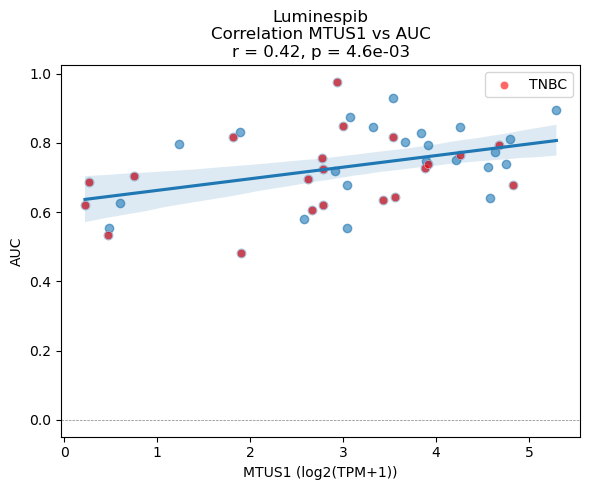

(0.4193186553498303, 0.00460787167864774)

In [5]:
from src.Depmap_utils import plot_expr_vs_measure_sensitivity
plot_expr_vs_measure_sensitivity(merged_df, 'Luminespib', measure_col='AUC', expr_col='MTUS1')

# 4. Pathways enrichment on putative targets 

ORA with Hallmark pathways

In [6]:
cor_df[
    (cor_df['p_value'] < 0.05) &
    (cor_df['correlation'] > 0) 
]['Putative_Target'].unique().tolist()


['NTRK1, NTRK2, NTRK3',
 'PLK1, PLK2, PLK3',
 'WEE1, CHEK1',
 'WEE1, PLK1',
 'NIK',
 'FGFR1, FGFR2, FGFR3',
 'CECR2, BRD2, BRD4, BRD9',
 'BRD4',
 'BCL2, BCL-XL, BCL-W, MCL1',
 'FLT3, JAK2, NTRK1, NTRK2, NTRK3',
 'JAK1, JAK2, JAK3',
 'ABL, SRC, Ephrins, PDGFR, KIT',
 'MRCKB_HUMAN',
 'HSP90',
 'JAK2, JAK3',
 'BRD2, BRD3, BRD4, BRDT',
 'CDK1',
 'Proteasome, CAPN1',
 'AURKA, AURKB, AURKC, others',
 'BCL2, BCL-XL, BCL-W',
 'ATR',
 'CHEK1, CHEK2',
 'Telomerase',
 'BRD2, BRD3, BRD4',
 'RNA helicase A',
 'Broad spectrum kinase inhibitor',
 'HDAC1, HDAC2, HDAC3, HDAC8',
 'JAK1, JAK2',
 'MEK1, MEK2',
 'Antimetabolite (DNA & RNA)',
 'Microtubule destabiliser',
 'PARP1, PARP2',
 'ERK2',
 'SIR2',
 'LSD1',
 'WIP1',
 'MET, KDR, TIE2, VEGFR3/FLT4, RON, PDGFR, FGFR1, EGFR',
 'IGF1R, IR',
 'PDGFR, KIT, VEGFR',
 'BRAF',
 'MCL1',
 'Microtubule stabiliser',
 'TOP2',
 'ERK1,ERK2',
 'CRBN',
 'ERK1, ERK2',
 'IGFR1']

## I consider all the putative targets from gdsc2 and Prism.

In [7]:
# currated gene list
gene_list = ['MRCKB','ABL',
 'NTRK1', 'NTRK2', 'NTRK3',
 'LSD1',
 'CDK1',
 'NIK',
 'BCL2', 'BCLXL', 'BCL-W',
 'BRD4',
 'MCL1',
 'LRRK2',
 'EP300',
 'CAPN1',
 'PIM1', 'PIM2', 'PIM3',
 'CECR2', 'BRD2', 'BRD4', 'BRD9',
 'HSP90','CDK4', 'NUAK1', 'PDGFRB',
 'TRPV4',
 'DHFR',
 'P2RX7',
 'AURKA', 'AURKB', 'PDPK1',
 'TOP2A',
 'MTOR',
 'BRAF', 'RAF1',
 'ADRA2A, ADRA2B, ADRA2C',
 'BRD2', 'BRD3', 'BRD4', 'BRDT',
 'ZNF215',
 'CDK2', 'CHEK1', 'GSK3B', 'KDR', 'PDK1', 'PDPK1',
 'CSF2RB, IL5RA',
 'ATP2A1',
 'ERBB2',
 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5',
 'PRMT6',
 'AURKA',
 'PDE4D',
 'CDC42',
 'TRPM8']
print("Number of genes:", len(gene_list))

Number of genes: 62


In [8]:
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets='MSigDB_Hallmark_2020', 
    organism='Human',
    outdir=None,
)

enr.res2d[['Term','Adjusted P-value','Overlap','Genes']]

,Term,Adjusted P-value,Overlap,Genes
0,PI3K/AKT/mTOR Signaling,0.000014,6/105,GSK3B;CDK4;CDK2;CDK1;RAF1;PDK1
1,G2-M Checkpoint,0.000191,6/200,TOP2A;CDK4;CHEK1;CDK1;AURKB;AURKA
2,E2F Targets,0.000191,6/200,TOP2A;CDK4;CHEK1;CDK1;AURKB;AURKA
3,Spermatogenesis,0.000267,5/135,CHRM4;CDK1;BRAF;MTOR;AURKA
4,Apoptosis,0.000493,5/161,PDGFRB;TOP2A;CDK2;ERBB2;MCL1
5,Mitotic Spindle,0.009413,4/199,TOP2A;CDC42;CDK1;AURKA
6,mTORC1 Signaling,0.009413,4/200,DHFR;GSK3B;AURKA;PDK1
7,Hypoxia,0.063087,3/200,BCL2;PIM1;PDK1
8,UV Response Dn,0.180731,2/144,PDGFRB;ERBB2
9,UV Response Up,0.180731,2/158,NTRK3;CDK2
